<a href="https://colab.research.google.com/github/kilka-bez-hvosta/aero_bot_personals/blob/main/AERO_BOT_%7C_Task_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

CAM_ANGLE = np.radians(69.0), np.radians(42.0)
LINE_WIDTH = 0.132
IMG_SIZE = 1280, 720
SPEED = 3 #м/с

In [ ]:
from typing import TypeAlias

Point3D: TypeAlias = tuple[float, float, float]


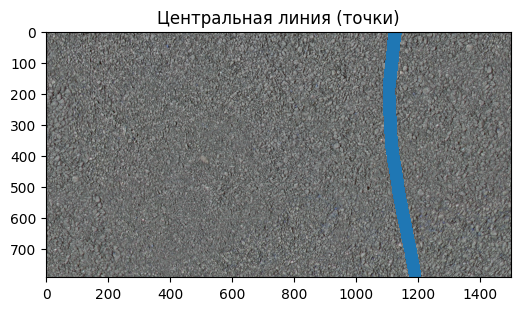

In [ ]:
binary = cv2.imread("12.png", cv2.COLOR_BGR2GRAY)
binary = 255 - binary
_, binary = cv2.threshold(binary, 254, 255, cv2.THRESH_BINARY)
kernel = np.ones((3, 3), np.uint8)
binary = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)
binary = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)
#skeleton = cv2.ximgproc.thinning(binary)
#points = np.column_stack(np.where(skeleton > 0))
points = np.column_stack(np.where(binary > 0))

plt.figure(figsize=(6, 6))
plt.imshow(cv2.imread("12.png"))
plt.scatter(points[:, 1], points[:, 0], s=1)
plt.title("Центральная линия (точки)")
plt.show()

In [ ]:
def get_line(
    image: str
    ) -> np.ndarray:

    binary = cv2.imread(image, cv2.IMREAD_GRAYSCALE)
    binary = 255 - binary
    _, binary = cv2.threshold(binary, 254, 255, cv2.THRESH_BINARY)

    binary = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)
    binary = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)
    #skeleton = cv2.ximgproc.thinning(binary)
    #points = np.column_stack(np.where(skeleton > 0))
    points = np.column_stack(np.where(binary > 0))

    #points = np.column_stack(np.where(skeleton > 0))

    return points



In [ ]:
def get_real_coords(
    drone_position: tuple[float, float, float],
    drone_angle: float,
    coords_on_img: tuple[float, float],
    ) -> tuple[float, float, float]:

    drone_angle = np.radians(drone_angle)
    drone_on_img = IMG_SIZE[0] / 2, IMG_SIZE[1] / 2

    dx, dy = coords_on_img[0] - drone_on_img[0], coords_on_img[1] - drone_on_img[1]

    scale_dx = 2*drone_position[2]*np.tan(CAM_ANGLE[0]/2)/IMG_SIZE[0]*dx
    scale_dy = 2*drone_position[2]*np.tan(CAM_ANGLE[1]/2)/IMG_SIZE[1]*dy

    cos_a, sin_a = np.cos(drone_angle), np.sin(drone_angle)

    real_dx = scale_dx * cos_a - scale_dy * sin_a
    real_dy = scale_dx * sin_a + scale_dy * cos_a

    new_drone_position = drone_position[0] + real_dx, drone_position[1] + real_dy, drone_position[2]
    return new_drone_position


In [ ]:
def filter_points(
    points,
    speed: float,
    max_angle_deg: int = 45
    ) -> np.ndarray:

    if len(points) == 0:
      return []

    filtered = [points[0]]

    for p in points[1:]:
      if np.linalg.norm(p - filtered[-1]) >= speed:
        filtered.append(p)
    filtered = [(y, x) for y, x in filtered if y < IMG_SIZE[1] / 2]

    return np.array(filtered)

In [ ]:
def filter_points_close(
    points,
    speed: float,
    max_angle_deg: int = 45
    ) -> np.ndarray:

    if len(points) == 0:
      return []

    return points[0]

    grid_size = int(speed)
    grid = {}
    filtered = []

    for p in points:
      gx, gy = int(p[0] // grid_size), int(p[1] // grid_size)
      found = False
      for dx in [-1, 0, 1]:
        for dy in [-1, 0, 1]:
          if (gx + dx, gy + dy) in grid:
            for q in grid[(gx + dx, gy + dy)]:
              if np.linalg.norm(p - q) < speed:
                found = True
                break
        if found:
          break

      if not found:
        filtered.append(p)
        grid.setdefault((gx, gy), []).append(p)

    filtered = [(y, x) for y, x in filtered if y < IMG_SIZE[1] / 2]

    return np.array(filtered)

In [ ]:
def choose_points(
    points,
    speed: float
    ) -> tuple[Point3D | None, Point3D | None]:

    if len(points) == 0:
      return None

    center = np.array((IMG_SIZE[0]/2, IMG_SIZE[1]/2))
    distances = np.linalg.norm(points - center, axis=1)
    idx_sorted = np.argsort(distances)

    point1 = tuple(points[idx_sorted[0]]) if len(points) > 0 else None
    point2 = tuple(points[idx_sorted[1]]) if len(points) > 1 else None

    return point1, point2

In [ ]:
def get_angle(
    point1: tuple[float, float],
    point2: tuple[float, float]
) -> float:
    vector = point2[0] - point1[0], point2[1] - point1[1]
    return -np.degrees(np.atan2(vector[1], vector[0])) + 90


In [ ]:
def get_next_point(
    image: str,
    drone_position: tuple[float, float, float],
    drone_angle: float,
    ) -> tuple[Point3D, Point3D | None, float | None]:

    speed_on_img = IMG_SIZE[0] / (2 * np.tan((CAM_ANGLE[0] + CAM_ANGLE[1]) / 2)) * SPEED / drone_position[2]
    line_width_on_image = IMG_SIZE[0] / (2 * np.tan(CAM_ANGLE[0] / 2)) * LINE_WIDTH / drone_position[2]

    points = get_line(image)

    if drone_position[2] < 1.5: # подсчитать когда будут ирл данные
      cand1, cand2 = points[0], None
    else:
      points = filter_points(points, speed_on_img)

      center = np.array((IMG_SIZE[0]/2, IMG_SIZE[1]/2))

      cand1, cand2 = choose_points(points, speed_on_img)
    if cand1 is not None and cand2 is not None:
      cand1 = np.array(cand1)
      cand2 = np.array(cand2)
      future_angle = get_angle(tuple(cand1), tuple(cand2))
      candidate = cand1
      #candidate = get_real_coords(drone_position, drone_angle, candidate)

      #return candidate, future_angle
      return cand1, cand2, future_angle
    else:
      return cand1, None, None

In [ ]:
def draw_result(image, candidate, future_angle):

  plt.imshow(cv2.imread(image))
  plt.axis('off')

  if candidate[0] is not None:
    plt.scatter(candidate[0][1], candidate[0][0], color='red', s=50)
  if candidate[1] is not None:
    plt.scatter(candidate[1][1], candidate[1][0], color='green', s=50)

  plt.scatter(IMG_SIZE[0]/2, IMG_SIZE[1]/2, color='pink', s=50)
  if future_angle is not None:
    length = 100
    dx = length * np.cos(np.radians(future_angle))
    dy = length * np.sin(np.radians(future_angle))
    plt.arrow(candidate[0][1], candidate[0][0], dx, dy, color='blue', width=2)

  plt.show()


1.png


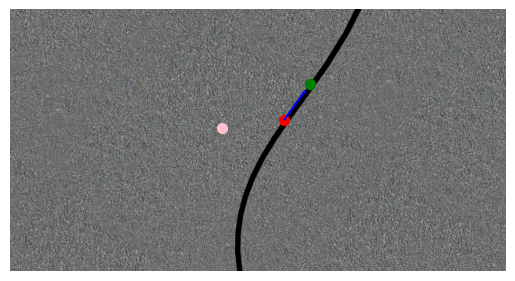

2.png


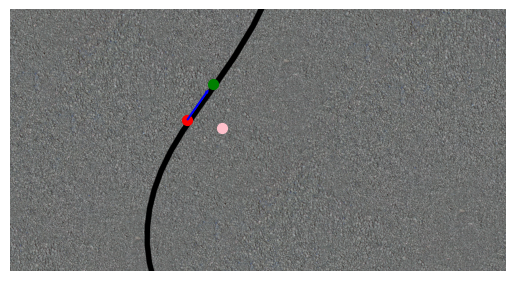

3.png


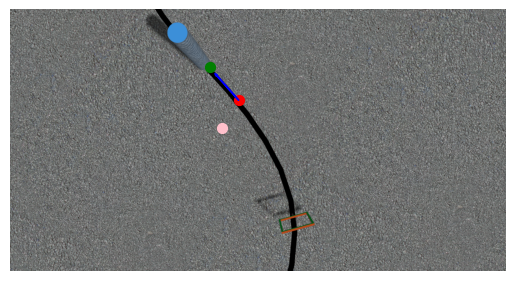

4.png


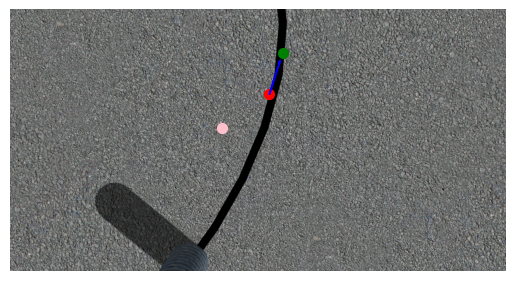

5.png


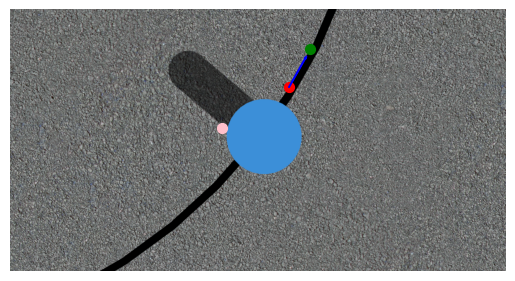

6.png


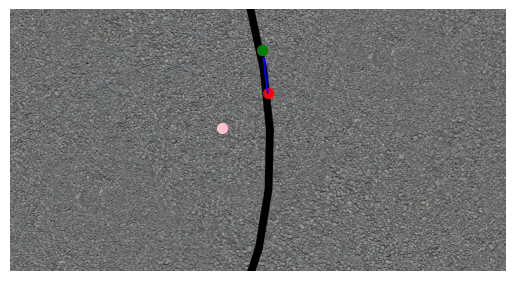

7.png


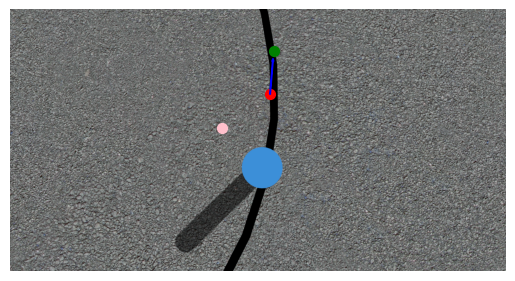

8.png


KeyboardInterrupt: 

In [ ]:
dr_pos = 0, 0, 10
dr_angle = 0

def test(image):
  c1, c2, ang = get_next_point(image, dr_pos, dr_angle)
  draw_result(image, (c1, c2), ang)

for i in range(1, 12):
  img = str(i) + '.png'
  print(img)
  test(img)
